# Evaluation of fidelity, utility, and privacy aspects of synthetic data sets
---
The goal of this notebook is to utilize a synthetic data generation tool to create synthetic tabular data. Afterward, the synthetic data’s fidelity, utility, and privacy aspects should be evaluated. However, already existing tools should be leveraged and not implemented in any way. Therefore the assignment primarily involves leveraging existing code and implementing necessary
boilerplate code to get some results.

This project was carried out for the course 194.055 VU Security, Privacy and Explainability in Machine Learning at TU Wien.

## Packages
For this notebook to run properly, we need to install the required packages

In [1]:
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


## General data & imports
In this section we define globally used variables and import the most used packages.

In [182]:
import numpy as np
import pandas as pd

from utils import train_and_evaluate

In [183]:
# define a random state
random_state = 12014500

# set the random state
np.random.seed(random_state)

## Dataset
In this notebook, we perform all action on the COMPASS-dataset. For our usecase we use the un-preprocessed version of it (./compass-scores-raw.csv). Therefore the following cells give a brief insight into the data itself.

In [184]:
file_path = './data/compas-scores-raw.csv'
df = pd.read_csv(file_path)

In [185]:
display(df.head())

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [186]:
df.shape

(60843, 28)

In [187]:
df.dtypes

Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted                    int64
dtype: object

In [188]:
df.isna().sum()

Person_ID                      0
AssessmentID                   0
Case_ID                        0
Agency_Text                    0
LastName                       0
FirstName                      0
MiddleName                 45195
Sex_Code_Text                  0
Ethnic_Code_Text               0
DateOfBirth                    0
ScaleSet_ID                    0
ScaleSet                       0
AssessmentReason               0
Language                       0
LegalStatus                    0
CustodyStatus                  0
MaritalStatus                  0
Screening_Date                 0
RecSupervisionLevel            0
RecSupervisionLevelText        0
Scale_ID                       0
DisplayText                    0
RawScore                       0
DecileScore                    0
ScoreText                     45
AssessmentType                 0
IsCompleted                    0
IsDeleted                      0
dtype: int64

In [189]:
df.describe()

,Person_ID,AssessmentID,Case_ID,ScaleSet_ID,RecSupervisionLevel,Scale_ID,RawScore,DecileScore,IsCompleted,IsDeleted
count,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.0,60843.0
mean,53683.206154,68061.029190,60209.128149,21.819536,1.630048,11.000000,5.081457,3.571701,1.0,0.0
std,14363.648515,7320.208226,9638.501654,0.932614,0.944220,4.966596,10.080518,2.617854,0.0,0.0
min,656.000000,649.000000,350.000000,17.000000,1.000000,7.000000,-4.790000,-1.000000,1.0,0.0
25%,52039.000000,62582.000000,56021.000000,22.000000,1.000000,7.000000,-2.090000,1.000000,1.0,0.0
50%,57321.000000,68229.000000,61261.000000,22.000000,1.000000,8.000000,-0.710000,3.000000,1.0,0.0
75%,62748.000000,73870.000000,66554.000000,22.000000,2.000000,18.000000,14.000000,5.000000,1.0,0.0
max,68608.000000,79678.000000,72045.000000,22.000000,4.000000,18.000000,51.000000,10.000000,1.0,0.0


### Data-insights
This subsections further investiges into the dataset, to get some insights on it. For this, we use the raw data and only one type of scores

In [190]:
df_insights = df[df['Scale_ID'] == 8]

In [191]:
date_of_birth_timestamp = pd.to_datetime(df_insights['DateOfBirth'], format='%m/%d/%y').dt.strftime('%m/%d/19%y')
date_of_birth_timestamp = pd.to_datetime(date_of_birth_timestamp, format='%m/%d/%Y')
df['YearOfBirth'] = date_of_birth_timestamp.dt.year

In [192]:
correlations_with_rawscore = {
    'YearOfBirth': date_of_birth_timestamp.dt.year.corr(df['RawScore']),
    'MonthOfBirth': date_of_birth_timestamp.dt.month.corr(df['RawScore']),
    'WeekdayOfBirth': date_of_birth_timestamp.dt.weekday.corr(df['RawScore'])
}
correlations_with_rawscore

{'YearOfBirth': 0.5352211306569021,
 'MonthOfBirth': 0.01359858157088456,
 'WeekdayOfBirth': -0.0108109308209829}

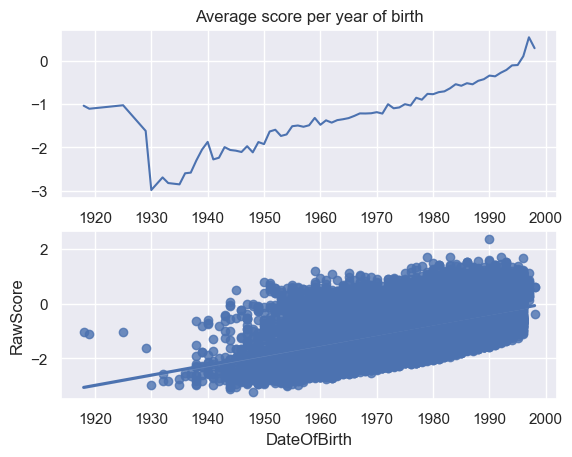

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
average_score_per_year = df_insights.groupby(date_of_birth_timestamp.dt.year)['RawScore'].mean()

axs[0].plot(average_score_per_year.index, average_score_per_year.values)
axs[0].set_title('Average score per year of birth')

sns.regplot(x=date_of_birth_timestamp.dt.year, y=df_insights['RawScore'], ax=axs[1])
plt.show()

In [194]:
df_insights.loc[df['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'

raw_ethnic_score_grouped = df_insights.groupby('Ethnic_Code_Text')['RawScore'].mean()
raw_ethnic_score_grouped

Ethnic_Code_Text
African-American   -0.462214
Arabic             -0.943200
Asian              -1.309815
Caucasian          -0.990190
Hispanic           -1.029564
Native American    -0.464795
Oriental           -1.042308
Other              -1.221505
Name: RawScore, dtype: float64

### PreProcessing
This sections deals, with the pre-processing we performed on the dataset.

In [195]:
nominal_features = ['Agency_Text', 'Ethnic_Code_Text', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'RecSupervisionLevel']
target = 'ScoreText'

First, we dropped all features, that either had redundant information, like `DisplayText` being the textual version of `Scale_ID`, or directly identifying informations like any kind of unique ids or names.

In [196]:
columns_to_drop = ['Person_ID', 'AssessmentID', 'Case_ID', 'LastName', 'FirstName', 'MiddleName', 'ScaleSet', 'RecSupervisionLevelText', 'DisplayText', 'RawScore', 'DecileScore', 'AssessmentType', 'IsCompleted', 'IsDeleted'] 
df_preprocessed = df.drop(columns_to_drop, axis=1)

Furthermore, we converted `Sex_Code_Text` to binary to make calculations easier and converted `DateOfBirth` and `Screening_Date` to Unix timestamp to make it workable with our classifers in the end. Also we unified `African-Am` and `African-American` into one class, since it has the same meaning.

In [197]:
df_preprocessed['Sex_Code_Text'] = df_preprocessed['Sex_Code_Text'].apply(lambda x: 1 if x == 'Male' else 0)
df_preprocessed['DateOfBirth'] = pd.to_datetime(df_preprocessed['DateOfBirth']).astype(int) // 10**9  # Convert to Unix timestamp
df_preprocessed['Screening_Date'] = pd.to_datetime(df_preprocessed['Screening_Date']).astype(int) // 10**9  # Convert to Unix timestamp
df_preprocessed.loc[df_preprocessed['Ethnic_Code_Text'] == 'African-Am', 'Ethnic_Code_Text'] = 'African-American'

Afterwards, we removed all records that had missing values in our label attribute `ScoreText`. Those records cannot be used in any way and therefore should be discarded.

In [198]:
df_preprocessed = df_preprocessed.dropna(subset=['ScoreText'])

The dataset provides scores for three different kinds of classifications-problems. We select only one to make our simple classifier do a better job.

In [199]:
df_preprocessed = df_preprocessed[df_preprocessed['Scale_ID'] == 8]

In [200]:
df_preprocessed.shape

(20245, 15)

#### Train/Test-Split
After this we perform the basic 80/20 split into train and test data.

In [201]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_preprocessed, test_size=0.2, random_state=random_state)

Lastly, we replaces all `NaN`-strings inside the train- and test-set individually with `np.nan` to make it more unified.

In [202]:
df_train.replace('NaN', np.nan, inplace=True)
df_test.replace('NaN', np.nan, inplace=True)

## Baseline Classifier
This sections simply trains and evaluates our baseline. We simply use a Random Forests because it should be an easy but robust classifier.

In [203]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, df_train, df_test, nominal_features, target)

{'accuracy': 0.8928130402568536,
 'precision': 0.9038317815324403,
 'recall': 0.8648715054938046,
 'f1': 0.8733412647813531}

## Data synthetization
This sections presents the creation and evaluation of our synthesized data. For this we use multiple instances from the [Synthetic Data Vault](https://github.com/sdv-dev/SDV) and two methods from [DataSynthesizer](https://github.com/DataResponsibly/DataSynthesizer). We only synthesize the training data, because we want to further evaluate on original test data.

### Synthetic Data Vault

In [110]:
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import run_diagnostic
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer, TVAESynthesizer
from sdmetrics.reports.single_table import QualityReport

from utils import generate_synthetic_data, evaluate_fidelity, evaluate_privacy_risks, evaluate_inference_risks

#### Metadata
First, of all we need to create a metadata object of our training data. This simply is a representation of our data.

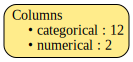

In [20]:
metadata = SingleTableMetadata()

try: 
    metadata = metadata.load_from_json('./synthesizers/metadata.json')
except: 
    metadata.detect_from_dataframe(df_train)
    metadata.save_to_json(filepath='./synthesizers/metadata.json')

metadata.visualize(
    show_table_details='summarized',
    output_filepath='./images/my_metadata.png'
)

Afterwards, we validate the metadata to ensure that it is correct.

In [21]:
metadata.validate_data(data=df_train)

#### GaussianCopulaSynthesizer
First we use the GaussianCopulaSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [22]:
synthetic_data_gc = generate_synthetic_data(GaussianCopulaSynthesizer(metadata, enforce_min_max_values=True), df_train, fit=False)

In [23]:
synthetic_data_gc.to_csv('./data/synthetic_data_GaussianCopulaSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [24]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_gc,metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 809.33it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 738.56it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [25]:
my_report = QualityReport()
my_report.generate(df_train, synthetic_data_gc, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 296.45it/s]|
Column Shapes Score: 96.52%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 62.17it/s]|
Column Pair Trends Score: 70.37%

Overall Score (Average): 83.45%



In [26]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.998518
1,Sex_Code_Text,TVComplement,0.996110
2,Ethnic_Code_Text,TVComplement,0.991479
3,DateOfBirth,KSComplement,0.589899
4,ScaleSet_ID,TVComplement,0.999321
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.999383
7,LegalStatus,TVComplement,0.997469
8,CustodyStatus,TVComplement,0.997715
9,MaritalStatus,TVComplement,0.991665


In [27]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/GaussianCopulaSynthesizer_pair_trends.png") 

![Column Pair Trends](./images/GaussianCopulaSynthesizer_pair_trends.png)

In [28]:
evaluate_fidelity(df_train, synthetic_data_gc)

{'CSTest': 0.9990080483172584,
 'KSComplement': 0.9243846217172965,
 'ContinuousKLDivergence': 0.7606295084583549,
 'DiscreteKLDivergence': 0.945688371974372,
 'SVCDetection': 0.21826308968047792}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [29]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_gc, df_test, nominal_features, target)

{'accuracy': 0.7540133366263275,
 'precision': 0.7197384058509758,
 'recall': 0.645978873395046,
 'f1': 0.6637658434151851}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [30]:
evaluate_privacy_risks(df_train, synthetic_data_gc)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.032794749729725355, ci=(0.021924003447158568, 0.04366549601229214))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.6573953721592822, baseline = 0.6713417975404845. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.3445969743237466, baseline = 0.35953957294646327. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.047737348352442026, baseline = 0.05271821456001425. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.99

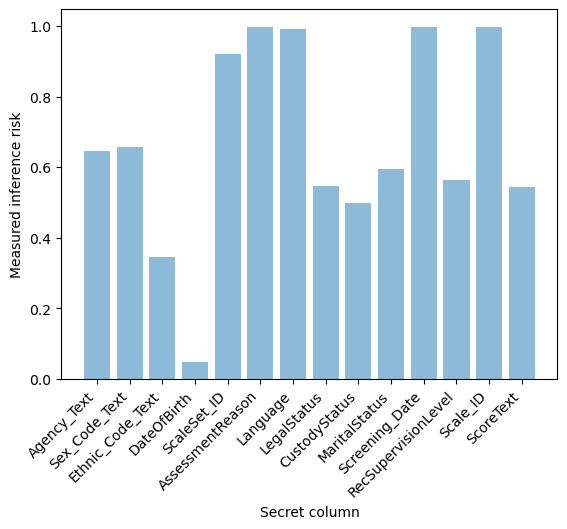

In [31]:
evaluate_inference_risks(df_train, synthetic_data_gc)

#### CTGANSynthesizer
Second we use the CTGANSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [32]:
synthetic_data_ctgan = generate_synthetic_data(CTGANSynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=False)

In [33]:
synthetic_data_ctgan.to_csv('./data/synthetic_data_CTGANSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [34]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_ctgan, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 668.13it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1190.21it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [35]:
my_report = QualityReport()
my_report.generate(df_train, synthetic_data_ctgan, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 271.44it/s]|
Column Shapes Score: 92.65%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 57.09it/s]|
Column Pair Trends Score: 65.65%

Overall Score (Average): 79.15%



In [36]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.947086
1,Sex_Code_Text,TVComplement,0.907755
2,Ethnic_Code_Text,TVComplement,0.863608
3,DateOfBirth,KSComplement,0.896765
4,ScaleSet_ID,TVComplement,0.954495
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.978822
7,LegalStatus,TVComplement,0.873611
8,CustodyStatus,TVComplement,0.859718
9,MaritalStatus,TVComplement,0.921956


In [37]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/CTGANSynthesizer_pair_trends.png") 

![Column Pair Trends](./images/CTGANSynthesizer_pair_trends.png)

In [38]:
evaluate_fidelity(df_train, synthetic_data_ctgan)

{'CSTest': 0.9653509131439245,
 'KSComplement': 0.9262575121429159,
 'ContinuousKLDivergence': 0.9359587095213218,
 'DiscreteKLDivergence': 0.9073109301724503,
 'SVCDetection': 0.44661819310389894}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [39]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_ctgan, df_test, nominal_features, target)

{'accuracy': 0.8821931341071869,
 'precision': 0.8942090833471434,
 'recall': 0.8461484600287045,
 'f1': 0.8599947538966844}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [40]:
evaluate_privacy_risks(df_train, synthetic_data_ctgan)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.09555366394513538, ci=(0.07743417357376373, 0.11367315431650704))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.



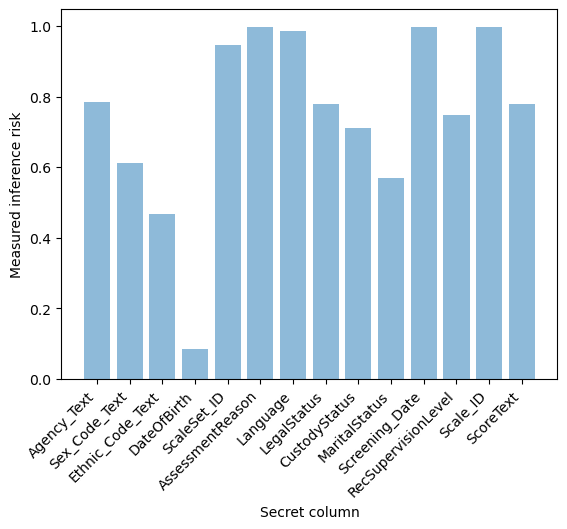

In [41]:
evaluate_inference_risks(df_train, synthetic_data_ctgan)

#### TVAESynthesizer
Third we use the TVAESynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [42]:
synthetic_data_tvae = generate_synthetic_data(TVAESynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=False)

In [43]:
synthetic_data_tvae.to_csv('./data/synthetic_data_TVAESynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [44]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_tvae, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 639.97it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1067.25it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [45]:
my_report = QualityReport()
my_report.generate(df_train, synthetic_data_tvae, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 270.97it/s]|
Column Shapes Score: 93.0%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 58.47it/s]|
Column Pair Trends Score: 66.8%

Overall Score (Average): 79.9%



In [46]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.946900
1,Sex_Code_Text,TVComplement,0.817301
2,Ethnic_Code_Text,TVComplement,0.900037
3,DateOfBirth,KSComplement,0.952828
4,ScaleSet_ID,TVComplement,0.968511
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.995925
7,LegalStatus,TVComplement,0.917572
8,CustodyStatus,TVComplement,0.969499
9,MaritalStatus,TVComplement,0.900654


In [47]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/TVAESynthesizer_pair_trends.png") 

![Column Pair Trends](./images/TVAESynthesizer_pair_trends.png)

In [48]:
evaluate_fidelity(df_train, synthetic_data_tvae)

{'CSTest': 0.9933496812210934,
 'KSComplement': 0.9029492878900139,
 'ContinuousKLDivergence': 0.8790471956421998,
 'DiscreteKLDivergence': 0.9411638437595499,
 'SVCDetection': 0.30412576504543354}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [51]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_tvae, df_test, nominal_features, target)

{'accuracy': 0.8933069893800939,
 'precision': 0.9045348555994689,
 'recall': 0.8654643748709366,
 'f1': 0.8737943612780241}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [52]:
evaluate_privacy_risks(df_train, synthetic_data_tvae)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.1822207359568921, ci=(0.15837194044398084, 0.20606953146980334))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.7570126963107268, baseline = 0.7580088695522411. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.952262651647558, baseline = 0.9552511713721012. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9941019

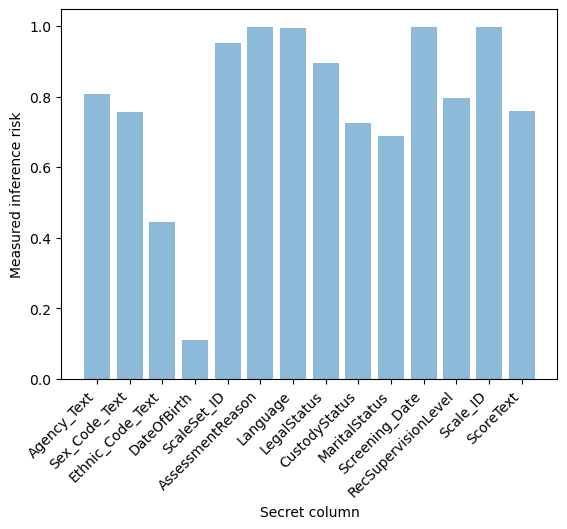

In [53]:
evaluate_inference_risks(df_train, synthetic_data_tvae)

#### CopulaGANSynthesizer
Lastly we use the CopulaGANSynthesizer, to synthesize and save the dataset. Afterwards we evaluate some metrics on the dataset. For more concrete explanations and conclusions, please take a look at our report.

In [54]:
synthetic_data_cgan = generate_synthetic_data(CopulaGANSynthesizer(metadata, enforce_min_max_values=True, epochs=100), df_train, fit=False)

In [55]:
synthetic_data_cgan.to_csv('./data/synthetic_data_CopulaGANSynthesizer.csv') #save synthetic data for reproducibility

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [56]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_cgan, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 840.28it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1043.88it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [57]:
my_report = QualityReport()
my_report.generate(df_train, synthetic_data_cgan, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 274.12it/s]|
Column Shapes Score: 92.29%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 62.82it/s]|
Column Pair Trends Score: 64.53%

Overall Score (Average): 78.41%



In [58]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.932329
1,Sex_Code_Text,TVComplement,0.853482
2,Ethnic_Code_Text,TVComplement,0.846876
3,DateOfBirth,KSComplement,0.901951
4,ScaleSet_ID,TVComplement,0.926031
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.973018
7,LegalStatus,TVComplement,0.964806
8,CustodyStatus,TVComplement,0.875834
9,MaritalStatus,TVComplement,0.938812


In [59]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/CopulaGANSynthesizer_pair_trends.png") 

![Column Pair Trends](./images/CopulaGANSynthesizer_pair_trends.png)

In [60]:
evaluate_fidelity(df_train, synthetic_data_cgan)

{'CSTest': 0.9538039790975126,
 'KSComplement': 0.9146085453198319,
 'ContinuousKLDivergence': 0.893460136390506,
 'DiscreteKLDivergence': 0.8946714683156579,
 'SVCDetection': 0.38210345977611226}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [61]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_cgan, df_test, nominal_features, target)

{'accuracy': 0.8653988639170166,
 'precision': 0.8807358003594011,
 'recall': 0.8209411298041577,
 'f1': 0.8362656609046129}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [62]:
evaluate_privacy_risks(df_train, synthetic_data_cgan)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.08160723856393315, ci=(0.06474803809836388, 0.09846643902950242))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.5388507564190633, baseline = 0.5876632452532711. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.998086

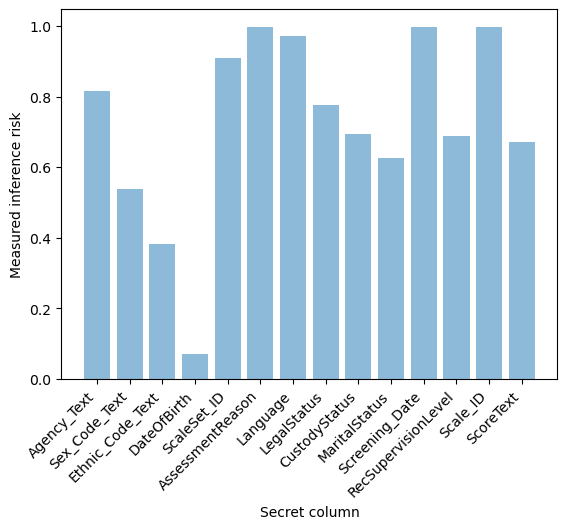

In [63]:
evaluate_inference_risks(df_train, synthetic_data_cgan)

### DataSynthesizer
Secondly, we implemented the DataSynthesizer, which is based on Bayesian Networks, to check how well this approach works on our sample data. For this we use two approaches. First we use independent-mode, which assumes all attributes are statistically indepentent to each other and second we use the correlation-mode which assumes non-independence between variables

In [80]:
from DataSynthesizer.lib.utils import display_bayesian_network

#### Independent attribute mode

In [96]:
synthetic_data_independet_mode, _ = generate_synthetic_data(df_train, 'independent_attribute_mode', 13)

Afterwards, we run a diagnostic check, wether the data generation was successful.

In [102]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_independet_mode, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 739.91it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 1059.17it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [103]:
from sdmetrics.reports.single_table import QualityReport

my_report = QualityReport()
my_report.generate(df_train, synthetic_data_independet_mode, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 229.56it/s]|
Column Shapes Score: 96.5%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 60.70it/s]|
Column Pair Trends Score: 67.76%

Overall Score (Average): 82.13%



In [104]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.965362
1,Sex_Code_Text,TVComplement,0.997469
2,Ethnic_Code_Text,TVComplement,0.938071
3,DateOfBirth,KSComplement,0.869906
4,ScaleSet_ID,TVComplement,0.987096
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.994011
7,LegalStatus,TVComplement,0.985429
8,CustodyStatus,TVComplement,0.960484
9,MaritalStatus,TVComplement,0.950543


In [105]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/DataSynthesizer_Independent_mode_pair_trends.png") 

![Column Pair Trends](./images/DataSynthesizer_Independent_mode_pair_trends.png)

In [106]:
evaluate_fidelity(df_train, synthetic_data_independet_mode)

{'CSTest': 0.958884680283752,
 'KSComplement': 0.9554416728410308,
 'ContinuousKLDivergence': 0.8721984302520253,
 'DiscreteKLDivergence': 0.844951751186254,
 'SVCDetection': 0.12341802287813142}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [107]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_independet_mode, df_test, nominal_features, target)

{'accuracy': 0.6090392689552976,
 'precision': 0.579323668676487,
 'recall': 0.40508334339413193,
 'f1': 0.37051144214762655}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [108]:
evaluate_privacy_risks(df_train, synthetic_data_independet_mode)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.03976796242032647, ci=(0.027809004509302633, 0.05172692033135031))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.5308813704869477, baseline = 0.5328737169699767. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.6474336397441378, baseline = 0.6673571045744267. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.3047500446631688, baseline = 0.32566968273497215. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.06068

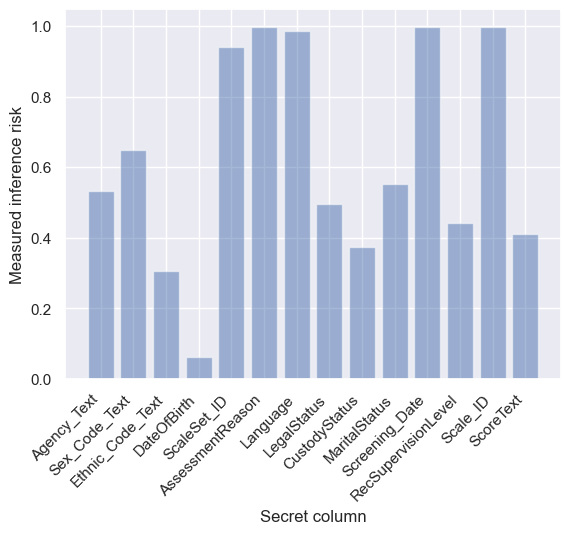

In [109]:
evaluate_inference_risks(df_train, synthetic_data_independet_mode)

#### Correlated attribute mode

In [113]:
synthetic_data_correlated_mode, describer = generate_synthetic_data(df_train, 'correlated_attribute_mode', 13)

================ Constructing Bayesian Network (BN) ================
Adding ROOT ScoreText
Adding attribute RecSupervisionLevel
Adding attribute LegalStatus
Adding attribute CustodyStatus
Adding attribute Agency_Text
Adding attribute DateOfBirth
Adding attribute MaritalStatus
Adding attribute ScaleSet_ID
Adding attribute Scale_ID
Adding attribute Screening_Date
Adding attribute Ethnic_Code_Text
Adding attribute Language
Adding attribute Sex_Code_Text
Adding attribute AssessmentReason
========================== BN constructed ==========================


In [115]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    RecSupervisionLevel has parents ['ScoreText'].
    LegalStatus         has parents ['RecSupervisionLevel', 'ScoreText'].
    CustodyStatus       has parents ['LegalStatus', 'RecSupervisionLevel'].
    Agency_Text         has parents ['CustodyStatus', 'RecSupervisionLevel'].
    DateOfBirth         has parents ['Agency_Text', 'RecSupervisionLevel'].
    MaritalStatus       has parents ['CustodyStatus', 'RecSupervisionLevel'].
    ScaleSet_ID         has parents ['Agency_Text', 'RecSupervisionLevel'].
    Scale_ID            has parents ['CustodyStatus', 'ScoreText'].
    Screening_Date      has parents ['Scale_ID', 'Agency_Text'].
    Ethnic_Code_Text    has parents ['ScaleSet_ID', 'RecSupervisionLevel'].
    Language            has parents ['DateOfBirth', 'LegalStatus'].
    Sex_Code_Text       has parents ['Language', 'Ethnic_Code_Text'].
    AssessmentReason    has parents ['ScaleSet_ID', 'Agency_Text'].


Afterwards, we run a diagnostic check, wether the data generation was successful.

In [116]:
diagnostic_report = run_diagnostic(real_data=df_train, synthetic_data=synthetic_data_correlated_mode, metadata=metadata)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 647.94it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 905.70it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



##### Fidelity
Now, we check for the fidelity by checking how similiar the synthetic data is in comparison to the original one.

In [117]:
from sdmetrics.reports.single_table import QualityReport

my_report = QualityReport()
my_report.generate(df_train, synthetic_data_correlated_mode, metadata.to_dict())

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 179.94it/s]|
Column Shapes Score: 96.97%

(2/2) Evaluating Column Pair Trends: |██████████| 91/91 [00:01<00:00, 59.67it/s]|
Column Pair Trends Score: 70.08%

Overall Score (Average): 83.53%



In [118]:
my_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,Agency_Text,TVComplement,0.961163
1,Sex_Code_Text,TVComplement,0.991356
2,Ethnic_Code_Text,TVComplement,0.971289
3,DateOfBirth,KSComplement,0.897629
4,ScaleSet_ID,TVComplement,0.978328
5,AssessmentReason,TVComplement,1.000000
6,Language,TVComplement,0.928439
7,LegalStatus,TVComplement,0.969313
8,CustodyStatus,TVComplement,0.958570
9,MaritalStatus,TVComplement,0.973512


In [119]:
fig = my_report.get_visualization(property_name='Column Pair Trends')
fig.write_image("./images/DataSynthesizer_correlated_mode_pair_trends.png") 

![Column Pair Trends](./images/DataSynthesizer_correlated_mode_pair_trends.png)

In [123]:
evaluate_fidelity(df_train, synthetic_data_correlated_mode)

{'CSTest': 0.8992415510740025,
 'KSComplement': 0.9727813451881123,
 'ContinuousKLDivergence': 0.8922450282263379,
 'DiscreteKLDivergence': 0.8283700628017812,
 'SVCDetection': 0.6136941024420108}

##### Utility
Secondly, we look how well our classifier performs on this newly generated dataset.

In [120]:
clf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=random_state)
train_and_evaluate(clf, synthetic_data_correlated_mode, df_test, nominal_features, target)

{'accuracy': 0.8873795999012102,
 'precision': 0.8948663157211749,
 'recall': 0.8601721106398292,
 'f1': 0.8655284066437904}

##### Privacy
Lastly, we look at the privacy aspect of the generated data. Therefore we analyse privacy and inference risks. We don't evaluate linkability risks for one simple reasons. The library is implemented for the usecase where we want to check wether you can link records from one dataset to another, but we are dealing with the same datasets. Furthermore our pre-processing would need to be reverted to let the code execute, which would simply be out of the scope for the expirement.
Especially, because the other two metrics give good insights.

In [121]:
evaluate_privacy_risks(df_train, synthetic_data_correlated_mode)

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.



{'univariate': PrivacyRisk(value=0.0019133792427775617, ci=(0.0, 0.0038267584855551234)),
 'multivariate': PrivacyRisk(value=0.10153070339422206, ci=(0.08290944359309571, 0.1201519631953484))}

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.

/Users/maxkleinegger/miniconda3/lib/python3.9/site-packages/anonymeter/stats/confidence.py:218: UserWarning:

Attack is as good or worse as baseline model. Estimated rates: attack = 0.9980866207572224, baseline = 0.9980866207572224. Analysis results cannot be trusted.



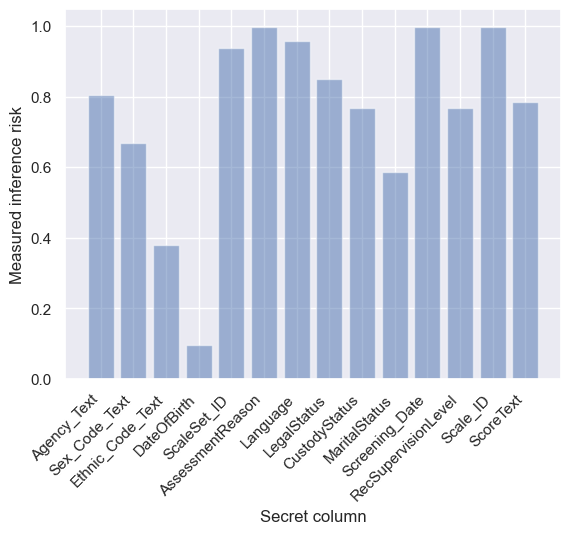

In [122]:
evaluate_inference_risks(df_train, synthetic_data_correlated_mode)